Lexical semantics


In this guide we will explore how to represent texts semantically using semantic vector representations of words (i.e., word embeddings)

# Text and Language

We will see how to: 
- (1) model/capture the meaning of words
- (2) find syntactic/linguistic structure of sentences 
- (3) how to extract/structure relevant information from text (for example, named entities)  

## Data Loading
We will be loading a corpus of Amazon reviews for the products in the category "Electronics"

In [1]:
# codecs library helps with reading from (or writing to) files with different encodings (e.g., UTF-8, ANSII, etc.)
import codecs

# specifying the location of the file containing our reviews
filepath = "unlabeled_reviews.txt" #reviews from amazon

# loading the content of the file and creating a list of texts from its lines (one review per line)
dataset = [l.strip() for l in list(codecs.open(filepath, "r", encoding = 'utf8', errors = 'replace').readlines())]
#.strip(): entfernt leerzeichen bzw. nach eingabe bestimmte zeichen wie z.b. semikolon
#.readlines(): returns all lines in a file as a list

## Data Exploration
... let's just look at some statistics and examples.

In [32]:
# let's see how many reviews we have in our dataset
print("We have: " + str(len(dataset)) + " reviews in the dataset.")

We have: 13153 reviews in the dataset.


In [3]:
# The first row is ..
print(dataset[0])

First of all why do you want a power UPS? There are some very good reasons. (1) You never want your machine to go down incorrectly because of a blackout. (2) You want to work with clean power only. (3) You want to monitor your PC power. (4) You want to prevent your PC from being damaged due to a power problem like a lighting strike and want surge protection. The first rule about UPS is to never trust the insurance claim. Get your PC insured elsewhere. These companies have a tendency not to support their insurance claims. I have a PC running some very high specifications with over six USB devices, LCD monitor, printer and Ethernet equipment, with everything on at the same time. I have never gone above 325W of usage and average between 250W and 300W when managing a high spec game and doing lots of background tasks. Even though I have a 400W Power Supply Unit (PSU) I will be upgrading to a 500W PSU because it is better quality model. The way I can monitor how many Watts I use is with UPS 

In [4]:
#proprocessing via spacey
# let's do some tokenization
from spacy.lang.en import English #models der sprache importieren lassen
nlp = English()

# create a Tokenizer with the default settings for English
# including punctuation rules and exceptions
tokenizer = nlp.tokenizer

# tokenize each of the rows
dataset_tokenized = [tokenizer(d) for d in dataset] #for d in dataset: return tokenizer(d)
print(dataset_tokenized[0][0]) #prints first token of the first dataset

First


In [5]:
type(dataset_tokenized[0])

spacy.tokens.doc.Doc

In [6]:
length_characters = [len(d) for d in dataset] #counts chars
length_words = [len(d) for d in dataset_tokenized] #counts only words

print(max(length_characters))
print(max(length_words))


9355
2020


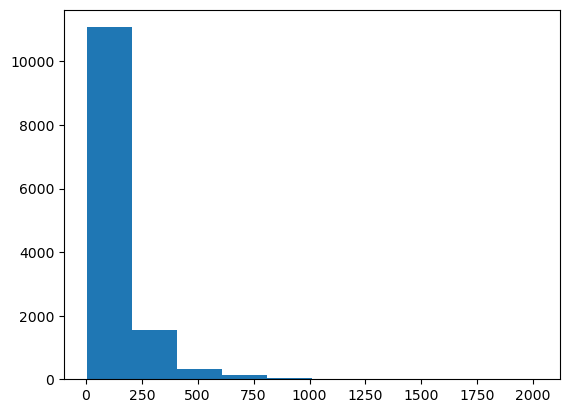

In [7]:
import matplotlib.pyplot as plt

plt.hist(length_words, bins = 10) #how many times words in how many docs appear
plt.show()
#biggest numer of words have low frequencies

## Latent Semantic Analysis

We will compute a term-document matrix, a matrix whose rows correspond to terms, whose columns correspond to documents, and whose element at position  (t,d)  is 1 if the document in column  d  contains the term in row  t , and is 0 otherwise. The matrix will be displayed as a pandas data frame to easily visualize term and document labels of rows and columns.

In [33]:
# For faster demonstration (also colab will run oom) let's only look at the first 100 documents
dataset_tokenized = dataset_tokenized[:100]

In [34]:
import pandas as pd
from scipy.sparse import lil_matrix #lil_matrix: good for slicing through matrices
from gensim.parsing.preprocessing import STOPWORDS #for the effective purge of stopwords

remove_list = list(STOPWORDS) + [",", ".", ":", "*", ";", "?", "!", "-"]

# let's assign contexts to terms
d = {}
for j, tokens in enumerate(dataset_tokenized): #enumerate: um 2 values nacheinander sortieren zu lassen
  for t in tokens:
    t = str(t).lower()
    if t not in remove_list:
      #The setdefault() method returns the value of the item with the specified key.
      #If the key does not exist, insert the key, with the specified value, see example below
      d[t] = d.setdefault(t, []) #setze t als item, sollte es nicht existieren, dann füge den entsprechenden wert (repräsentiert durch die []) hinzu
      d[t].append(j) 
A = lil_matrix((len(d.keys()), len(dataset_tokenized)), dtype=int)
for i, t in enumerate(d.keys()):
    for j in d[t]:
        A[i, j] = 1   
A_df = pd.DataFrame(A.toarray(), index=d.keys(), columns=range(len(dataset_tokenized))) 
A_df

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
want,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
power,1,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ups,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
good,1,1,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,1
reasons,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
experimenting,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
closet,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
recommendations,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
source,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Now, we compute the SVD (only for demonstration, we compute the full SVD)

In [10]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#https://stackoverflow.com/questions/47022997/jupyter-the-kernel-appears-to-have-died-it-will-restart-automatically
"""set the environment variable KMP_DUPLICATE_LIB_OK=TRUE to allow the program to continue to execute, 
but that may cause crashes or silently produce incorrect results. For more information, please see 
http://www.intel.com/software/products/support/"""

from scipy.linalg import svd #svd: decomposes matrix into 3 other matrices

u, s, vt = svd(A.toarray())

Let's look at the obtained matrices ...

In [11]:
u.shape

(1817, 1817)

The index of our term-document data frame contains the words in our vocabulary. Their index number corresponds to the position (row) in the matrix u.

In [12]:
ind = 40 
A_df.index[ind] #index: prints word at position

'lcd'

In [13]:
u[ind] #übereinstimmungen

array([-2.45625113e-02,  3.95267917e-02, -4.02717808e-02, ...,
        1.93054992e-07,  1.93054992e-07,  1.93054992e-07])

We reduce the dimensionality by keeping only the most indicative columns.

In [14]:
k = 10
u_k = u[:,:k] #ausschnitt aus der matrix über index

In [15]:
u_k[ind]

array([-0.02456251,  0.03952679, -0.04027178,  0.02526172, -0.00737585,
        0.00510197, -0.00010077,  0.00369189, -0.00143189, -0.00301541])

We can use the obtained dense vectors for similarity comparisons.

In [16]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(u_k, u_k)
similarity_matrix

array([[ 1.        ,  0.57195566,  0.39213498, ...,  0.35740397,
         0.35740397,  0.35740397],
       [ 0.57195566,  1.        ,  0.6033461 , ..., -0.08438893,
        -0.08438893, -0.08438893],
       [ 0.39213498,  0.6033461 ,  1.        , ..., -0.08132205,
        -0.08132205, -0.08132205],
       ...,
       [ 0.35740397, -0.08438893, -0.08132205, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.35740397, -0.08438893, -0.08132205, ...,  1.        ,
         1.        ,  1.        ],
       [ 0.35740397, -0.08438893, -0.08132205, ...,  1.        ,
         1.        ,  1.        ]])

In [17]:
import numpy as np
np.argsort(similarity_matrix[ind]) #argsort(): indirect sort along a given axis, indices of value are arranged in ascending order

array([721, 718, 720, ..., 119,  52,  55], dtype=int64)

In [18]:
similarity_matrix[ind][4]

1.0

In [19]:
A_df.index[4]

'reasons'

## Word Embeddings and Semantic Similarity

SpaCy also allows you to easily load and use pretrained Word2Vec embeddings. These vectors capture meaning of words better than LSA. In order to load the embeddings, you need to use either the medium-sized or large Spacy models (ending with "md" or "lg"), the small models (ending with "sm") do not pack word embeddings. 

In [51]:
import spacy
import time #individual: import for time

# we're going to have to first download the spacy model "en_core_web_md" 
nlp = spacy.load('en_core_web_md')

# Let's analyse word similarities based on word embeddings
word1 = "dog"
word2 = "puppy"

d1 = nlp(word1)
d2 = nlp(word2)

print("Vector of " + word1 + ":")
print(d1.vector)

print("Vector of " + word2 + ":")
print(d2.vector)

sim = d1.similarity(d2) #.similarity checks the similarity between words

print()
print("Semantic similarity between " + word1 + " and " + word2 + ": " + str(sim))

print(f'{time.process_time()}s') #individual: using the time function

Vector of dog:
[-0.72483    0.42538    0.025489  -0.39807    0.037463  -0.29811
 -0.28279    0.29333    0.57775    1.2205    -0.27903    0.80879
 -0.71291    0.045808  -0.46751    0.55944    0.42745    0.58238
  0.20854   -0.42718   -0.40284   -0.048941   0.1149    -0.6963
 -0.03338    0.052596  -0.22572   -0.35996    0.47961   -0.38386
 -0.73837    0.1718     0.52188    0.45584   -0.026621   0.48831
  0.67996   -0.73345   -0.27078    0.41739    0.1947     0.27389
 -0.70931   -0.45317   -0.22574   -0.12617    0.03268    0.142
  0.53923   -0.61285   -0.5322     0.19479    0.13889   -0.020284
  0.088162   0.85337    0.039407   0.11529   -0.42646    0.74832
  0.34421   -0.59462    0.0040537  0.027203  -0.063394   0.26538
  0.34757    0.21395   -0.39799   -0.027067  -0.36132    0.31979
  0.55813   -0.5652     0.55382    0.03928   -0.26933   -0.14705
  0.74032   -0.50566    0.023765   0.62273   -0.79388   -0.25165
  0.11992   -0.43056    1.0614     0.58571    0.8856    -0.056054
  0.055826 

#### Document-level similarity: 

Document embeddings are computed as averages of their word embeddings by SpaCy. Let us compute the vectors for all reviews in our collection. 

In [52]:
import numpy as np

def mat_norm(mat, norm_order=2, axis=1):
    return mat / np.transpose([np.linalg.norm(mat, norm_order, axis)]) #normierung der matrix hinsichtlich deren länge


review_vectors = []

#https://stackoverflow.com/questions/51369858/spacy-nlp-pipe-returns-generator
for doc in nlp.pipe(dataset[:1000], disable=["tagger", "parser", "ner"]): #the pipe() changes data in the DataFrame object
    review_vectors.append(doc.vector)
    
# let us stack these vectors into a matrix, so that we can later easily compute semantic similarities for all pairs of reviews
reviews_matrix = np.array(review_vectors)
print(reviews_matrix.shape)

# fast way of computing cosines for all pairs of vectors

# each vector in "reviews_matrix" should be divided with its norm (L2-normalized): function mat_norm
rev_mat_norm = mat_norm(reviews_matrix)

# then the cosines are simply dot products between the vectors: matrix multiplied with its own inverse: function cosine_mats
similarities = np.matmul(rev_mat_norm, np.transpose(rev_mat_norm)) #matmul = matrix product between 2 matrices

print(similarities.shape)
print(similarities[:50, :50])

C:\ProgramData\Anaconda3\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


(1000, 300)
(1000, 1000)
[[1.0000001  0.9861927  0.98495793 ... 0.96748257 0.9790993  0.9745928 ]
 [0.9861927  1.         0.9790375  ... 0.97634804 0.98212504 0.9795139 ]
 [0.98495793 0.9790375  1.         ... 0.9606142  0.9806931  0.9667785 ]
 ...
 [0.96748257 0.97634804 0.9606142  ... 1.         0.9766625  0.9678735 ]
 [0.9790993  0.98212504 0.9806931  ... 0.9766625  1.0000001  0.97203153]
 [0.9745928  0.9795139  0.9667785  ... 0.9678735  0.97203153 1.0000002 ]]


Let's find the pairs of documents with the largest similarities (i.e., largest scores in the "similarities" matrix)

In [53]:
def sort_values_by_indices(mat): #sort docs by most similarity
    print(np.sort(mat, axis=None))
    print(np.argsort(mat, axis=None))
    # unravel index: converts a flat index or array of flat indices into a tuple of coordinate arrays.
    #more: https://stackoverflow.com/questions/48135736/what-is-an-intuitive-explanation-of-np-unravel-index
    print(np.unravel_index(np.argsort(mat, axis=None), mat.shape))
    print(np.dstack(np.unravel_index(np.argsort(mat, axis=None), mat.shape)))#dstack: combine multiple arrays into 1 array
    return np.dstack(np.unravel_index(np.argsort(mat, axis=None), mat.shape))[0]

In [54]:
sorted_similarities = sort_values_by_indices(similarities)

[0.11021045 0.11021045 0.11892603 ... 1.0000005  1.0000005  1.0000005 ]
[576175 175576 381576 ... 187187 634634 668668]
(array([576, 175, 381, ..., 187, 634, 668], dtype=int64), array([175, 576, 576, ..., 187, 634, 668], dtype=int64))
[[[576 175]
  [175 576]
  [381 576]
  ...
  [187 187]
  [634 634]
  [668 668]]]


In [58]:
sorted_similarities

array([[576, 175],
       [175, 576],
       [381, 576],
       ...,
       [187, 187],
       [634, 634],
       [668, 668]], dtype=int64)

In [60]:
# as we are looking at 1000 documents, the first 2000 most similar pairs will always be the document with itself
most_similar = list(reversed(sorted_similarities))[2000:]
print(most_similar)

#individual note: check similarity of specific vectors
#print(similarities[659][626])

KeyboardInterrupt: 

Word/document embeddings allow us to detect similarities between documents even if they don't use same words. This is semantic similarity (vs. just word overlap). 

In [26]:
print(dataset[527]) #596,  79
print()
print(dataset[454])

While I am pleased with the quality of sound this system gives me, I am a little disappointed. I've had this thing for a couple years now, about 9 months in it stopped giving me sound. So I went back and replaced it. They didn't even ask what the problem was, they gave no arguement because they had had so many returns and replacements. Then over the past few months the DVD player has been making a pretty loud noise whenever I use it, I have to turn the volume up pretty high just to not hear it. And now the player has stopped working completely. I have a DVD in there that I can't get out (which for the record is part of a Sopranos season, they dont sell the discs seperatly and their seasons are expensive which is pretty annoying to replace). Bose failed me once, shame on them. They failed me twice, shame on me. I'm gonna go with something else

I've had this MP3 since Xmas 05. It gave me trouble initially then the problem went away. Since July it hasn't worked for more than a few hours,


## Linguistic/Syntactic Analysis of Text

Parsing and part-of-speech-tagging


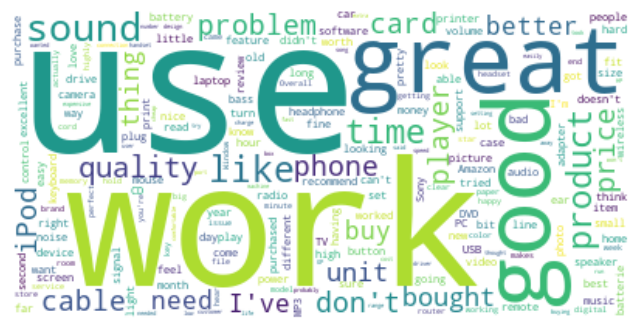

In [27]:
# wordcloud is a Python library for generating word clouds from text
import wordcloud
from wordcloud import WordCloud

# matplotlib is a Python library for plotting / rendering data and graphs of all kinds
import matplotlib.pyplot as plt

# concatenating all our reviews into one long text
big_text = " ".join(dataset)

# creating an object of WordCloud which we will then depict: defining white background and feeding our big text
wcloud = WordCloud(collocations = False, background_color = "white", stopwords = remove_list).generate_from_text(big_text)

# setting the size of the figure for wordclous plot
plt.figure(figsize=(8,7))

# plotting the created wordcloud
plt.imshow(wcloud, interpolation = "bilinear")
# we don't want to plot the axis
plt.axis("off")
# showing the plot
plt.show()

#note: weiteres beispiel hier => https://www.datacamp.com/tutorial/wordcloud-python
#am häufigsten verwendete wörter sind am größten dargestellt

### Linguistic annotations: POS-tagging and dependency parsing
SpaCy has pre-trained models for POS-tagging and dependency parsing


In [61]:
# parsing and pos-tagging may take longer on large datasets, so let's only demonstrate the functionality on first N reviews in our collection
N = 50
small_dataset = dataset[:N]

for doc in nlp.pipe(small_dataset, disable=["ner"]): #running faster without "ner"
    # POS-tagging and parses are performed on a sentence-level (not document level, like tokenization)
    for sent in doc.sents:
        print(sent.text)
        print("------------------------------------")
        for tok in sent:
            # tok.i index of the token in the document
            # sent.start index of the starting token of the sentence in the document
            # tok.tag_ is the fine-grained POS-tag; 
            # tok.pos_ is the coarse-grained POS-tag; 
            # tok.dep_ is the dependency relation from the governing token to this token
            # tok.head is the token which is the syntactic head of the current token (.text is it's text, .i its index in the document)
            print(tok.i - sent.start, tok.text, tok.tag_, tok.pos_, tok.dep_, tok.head.text, "(" + str(tok.head.i - sent.start) + ")")
        print()
        
#output: line1: "First" is governed by "want"

First of all why do you want a power UPS?
------------------------------------
0 First RB ADV advmod want (6)
1 of IN ADP prep First (0)
2 all DT PRON pobj of (1)
3 why WRB SCONJ advmod want (6)
4 do VBP AUX aux want (6)
5 you PRP PRON nsubj want (6)
6 want VB VERB ROOT want (6)
7 a DT DET det UPS (9)
8 power NN NOUN compound UPS (9)
9 UPS NNP PROPN dobj want (6)
10 ? . PUNCT punct want (6)

There are some very good reasons.
------------------------------------
0 There EX PRON expl are (1)
1 are VBP VERB ROOT are (1)
2 some DT DET det reasons (5)
3 very RB ADV advmod good (4)
4 good JJ ADJ amod reasons (5)
5 reasons NNS NOUN attr are (1)
6 . . PUNCT punct are (1)

(1) You never want your machine to go down incorrectly because of a blackout.
------------------------------------
0 ( -LRB- PUNCT punct want (5)
1 1 LS X meta want (5)
2 ) -RRB- PUNCT punct 1 (1)
3 You PRP PRON nsubj want (5)
4 never RB ADV neg want (5)
5 want VBP VERB ROOT want (5)
6 your PRP$ PRON poss machine (7)
7 machin

The first time I saw this piece was at Wal-mart.
------------------------------------
0 The DT DET det time (2)
1 first JJ ADJ amod time (2)
2 time NN NOUN ROOT time (2)
3 I PRP PRON nsubj saw (4)
4 saw VBD VERB relcl time (2)
5 this DT DET det piece (6)
6 piece NN NOUN nsubj was (7)
7 was VBD AUX ccomp saw (4)
8 at IN ADP prep was (7)
9 Wal NNP PROPN pobj at (8)
10 - JJ ADJ pobj at (8)
11 mart NN NOUN pobj at (8)
12 . . PUNCT punct time (2)

I had listened to Sony,Philips, JVC, Panasonic, RCA in that order, the difference was instantly clear.
------------------------------------
0 I PRP PRON nsubj listened (2)
1 had VBD AUX aux listened (2)
2 listened VBN VERB ccomp was (19)
3 to IN ADP prep listened (2)
4 Sony NNP PROPN pobj to (3)
5 , , PUNCT punct Sony (4)
6 Philips NNP PROPN appos Sony (4)
7 , , PUNCT punct Philips (6)
8 JVC NNP PROPN conj Philips (6)
9 , , PUNCT punct JVC (8)
10 Panasonic NNP PROPN conj JVC (8)
11 , , PUNCT punct Panasonic (10)
12 RCA NNP PROPN conj Panasonic (10

3 however RB ADV advmod work (5)
4 , , PUNCT punct work (5)
5 work VBP VERB ROOT work (5)
6 with IN ADP prep work (5)
7 my PRP$ PRON poss card (10)
8 compact JJ ADJ amod card (10)
9 flash NN NOUN compound card (10)
10 card NN NOUN pobj with (6)
11 . . PUNCT punct work (5)

Then, inexplicably, it stopped functioning entirely.
------------------------------------
0 Then RB ADV advmod stopped (5)
1 , , PUNCT punct stopped (5)
2 inexplicably RB ADV advmod stopped (5)
3 , , PUNCT punct stopped (5)
4 it PRP PRON nsubj stopped (5)
5 stopped VBD VERB ROOT stopped (5)
6 functioning VBG VERB xcomp stopped (5)
7 entirely RB ADV advmod functioning (6)
8 . . PUNCT punct stopped (5)

I unplugged it and plugged it back in and scanned for hardware changes in Device Manager but the card was dead.
------------------------------------
0 I PRP PRON nsubj unplugged (1)
1 unplugged VBD VERB ROOT unplugged (1)
2 it PRP PRON dobj unplugged (1)
3 and CC CCONJ cc unplugged (1)
4 plugged VBD VERB conj unplugged 

In [29]:
# displacy sublibrary part of SpaCy lets us visualize the dependency parse of a sentence
from spacy import displacy

sentence = "First of all, why do you want a power UPS?"
#sentence = input("Please enter a correct full sentence ...")

sent = nlp(sentence)
#displacy.serve(sent, style = "dep") #display.serve is better used for web servers only (jupyter info)
displacy.render(sent, style = "dep") #alt. to display.serve
#Serve a dependency parse tree or named entity visualization to view it in your browser. Will run a simple web server

## Named Entity Recognition

### Data Loading

We will be working with messages from the "20 Newsgroups dataset", which comes with scikit-learn and can be easily loaded

In [62]:
# loading the texts from an existing dataset, the famous "20 news groups" 
from sklearn.datasets import fetch_20newsgroups

# filtering news from the categories "talk.politics.misc" and "talk.politics.mideast"
ng_data = fetch_20newsgroups(subset='train', categories = ["talk.politics.misc", "talk.politics.mideast"])

print(len(ng_data.data))

num_docs = 100
texts = ng_data.data[: num_docs]

1029


### NER with SpaCy

In [63]:
# Let's go back to our friend SpaCy (and its visualization sub-library *displacy*)
import spacy

# the default nlp pipeline will perform tokenization, POS-tagging, dependency parsing, and named entity recognition
nlp = spacy.load("en_core_web_sm")



C:\ProgramData\Anaconda3\lib\site-packages\spacy\util.py:837: UserWarning: [W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [64]:
ind = 9
text = texts[ind]
# running the spacy pipeline, without pos-tagging and parsing, on the newsgroup texts

doc = nlp(text)
print(text)

print()
print("Entities: \n--------------------------------")

# you can see the meaning of NER labels from SpaCy here: https://spacy.io/api/annotation#named-entities
for ent in doc.ents:
    print(ent.text + " (" + ent.label_ + "); start: character " + str(ent.start_char) + "; end: character " + str(ent.end_char))

From: hernlem@chess.ncsu.edu (Brad Hernlem)
Subject: Re: was:Go Hezbollah!
Reply-To: hernlem@chess.ncsu.edu (Brad Hernlem)
Organization: NCSU Chem Eng
Lines: 36


In article <93y04m18d459@witsend.uucp>, "D. C. Sessions" <dcs@witsend.tnet.com> writes:

|>   Please clarify your standards for rules of engagement.  As I
|>   understand it, Israelis are at all times and under all
|>   circumstances fair targets.  Their opponents are legitimate
|>   targets only when Mirandized, or some such?
|> 
|>   I'm sure that this makes perfect sense if you grant *a*priori*
|>   that Israelis are the Black Hats, and that therefore killing
|>   them is automatically a Good Thing (Go Hezbollah!).  The
|>   corollary is that the Hezbollah are the White Hats, and that
|>   whatever they do is a Good Thing, and the Israelis only prove
|>   themselves to be Bad Guys by attacking them.
|> 
|>   This sounds suspiciously like a hockey fan I know, who cheers
|>   when one of the players on His Team uses his stic

In [68]:
from spacy import displacy

# you can also nicely visualize the named entities
#displacy.serve(doc, style="ent")

#faster in this case (see above): use displacy.render instead of displacy.serve
displacy.render(doc, style="ent")

## Rule-based relation extraction

First, we'll examine some **rule-based matching**. Let's do one simple pattern that extracts is-a/type-of relations between entities: "X such as Y"


In [70]:
import spacy
from spacy.matcher import Matcher 

nlp = spacy.load("en_core_web_sm")
matcher = Matcher(nlp.vocab)

pattern_suchas1 = [[{'POS':'NOUN'}, {'TEXT': 'such'}, {'TEXT': 'as'}, {'POS': 'PROPN'}]] #insert at position1 e.g. POS:ADJ to print more
pattern_suchas2 = [[{'POS':'NOUN'}, {'TEXT': 'such'}, {'TEXT': 'as'}, {'ENT_TYPE': "ORG"}]] # 383 is the integer code for "ORG", 384 for "GPE"
                       
text = "EU plan to copy Australia and make big tech companies such as Google pay for news. In countries such as Australia, the tech giants such as Google already have to pay more."

In [71]:
def find_print_matches(pattern, text):
    matcher.add("m", pattern)
    doc = nlp(text)
    matches = matcher(doc)

    for m in matches:
        span = doc[m[1]:m[2]]
        print(span.text)

In [72]:
find_print_matches(pattern_suchas2, text)

companies such as Google
giants such as Google
